In [23]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from configs.ve import cifar10_ncsnpp_continuous as configs
from sde_lib import VESDE
from models import ncsnpp
from env import RK45Env
import models.utils as mutils
import torch
import numpy as np
import sampling
import datasets
from utils import restore_checkpoint
from models.ema import ExponentialMovingAverage
from losses import get_optimizer

def image_grid(x):
  size = config.data.image_size
  channels = config.data.num_channels
  img = x.reshape(-1, size, size, channels)
  w = int(np.sqrt(img.shape[0]))
  img = img.reshape((w, w, size, size, channels)).transpose((0, 2, 1, 3, 4)).reshape((w * size, w * size, channels))
  return img

def show_samples(x):
  x = x.permute(0, 2, 3, 1).detach().cpu().numpy()
  img = image_grid(x)
  plt.figure(figsize=(8,8))
  plt.axis('off')
  plt.imshow(img)
  plt.show()


ckpt_filename = "exp/ve/cifar10_ncsnpp_continuous/checkpoint_24.pth"
config = configs.get_config()  
sde = VESDE(sigma_min=config.model.sigma_min, sigma_max=config.model.sigma_max, N=config.model.num_scales)
score_model = mutils.create_model(config)
optimizer = get_optimizer(config, score_model.parameters())
ema = ExponentialMovingAverage(score_model.parameters(),
                               decay=config.model.ema_rate)
state = dict(step=0, optimizer=optimizer,
             model=score_model, ema=ema)

state = restore_checkpoint(ckpt_filename, state, config.device)
ema.copy_to(score_model.parameters())

env = RK45Env(
    sde=sde, 
    model=score_model, 
    env_num=64, 
    device=torch.device("cuda"), 
    use_opt=True, 
    compute_opt=False
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


D:\myproject\score_sde_pytorch\utils.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_state = torch.load(ckpt_dir, map_location=device)


1 1.0 -0.08185571432113647
2 0.9988294839859009 -0.07667027413845062
3 0.9966434836387634 -0.06705504655838013
4 0.9949653148651123 -0.05971478670835495
5 0.9865740537643433 -0.024412255734205246
6 0.9850822687149048 -0.018824875354766846
7 0.9832175374031067 -0.011712233535945415
8 0.9832175374031067 -0.010899564251303673
64
9 0.9792894124984741 0.004223048686981201
10 0.9773253202438354 0.011125564575195312
11 0.9675048589706421 0.046159736812114716
12 0.9657590389251709 0.05326045677065849
13 0.9635766744613647 0.06055565923452377
14 0.9635766744613647 0.05880337208509445
63
15 0.9599132537841797 0.07338710874319077
16 0.957912027835846 0.079584501683712
17 0.947905957698822 0.10956332087516785
18 0.9461270570755005 0.1138940155506134
19 0.9439035654067993 0.1202196478843689
20 0.9439035654067993 0.12134651839733124
1
21 0.9596190452575684 0.072283074259758
22 0.9576206207275391 0.07850933074951172
23 0.9476284980773926 0.10860594362020493
24 0.9458520412445068 0.11292725801467896
2

ValueError: zero-size array to reduction operation minimum which has no identity

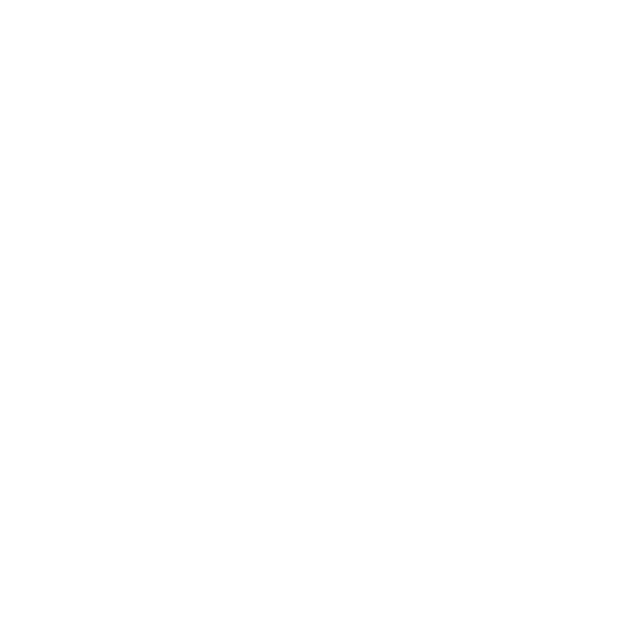

In [24]:
samples = None
def callback(env, td):
    global samples, step
    samples = td["z"][td["done"]]
    
rollout = env.rollout(1000, break_when_any_done=True, callback=callback)
samples = rollout["z"][rollout["done"][:, -1], -1]
show_samples(samples)

t, x:  1 1.0 -0.22275213556866255
t, x:  2 0.9988285943487363 -0.21622913024503
t, x:  3 0.9966373669498447 -0.2040272188295953
t, x:  4 0.9949560504247671 -0.1948237127081378
t, x:  5 0.9865494677993789 -0.1502910462175841
t, x:  6 0.9850549642215322 -0.14302456526270038
t, x:  7 0.9831868347492236 -0.13401739932775292
t, x:  8 0.9831868347492236 -0.1333477595110529
t, x:  9 0.9792236503702269 -0.1135519568269144
t, x:  10 0.9772420581807284 -0.10453289964837953
t, x:  11 0.9673340972332365 -0.05873183711780235
t, x:  12 0.9655726819536824 -0.04930269074985444
t, x:  13 0.9633709128542397 -0.03986595628541237
t, x:  14 0.9633709128542397 -0.04237891772094826
t, x:  15 0.9594908293180162 -0.02597085973127648
t, x:  16 0.9575507875499045 -0.018355156768696746
t, x:  17 0.9478505787093459 0.01818008024452851
t, x:  18 0.9461260971376909 0.02285951066268574
t, x:  19 0.9439704951731224 0.03075173830375158
t, x:  20 0.9439704951731224 0.03301998005032236
t, x:  21 0.9396728504023033 0.0483

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.081156164..1.0408775].


176


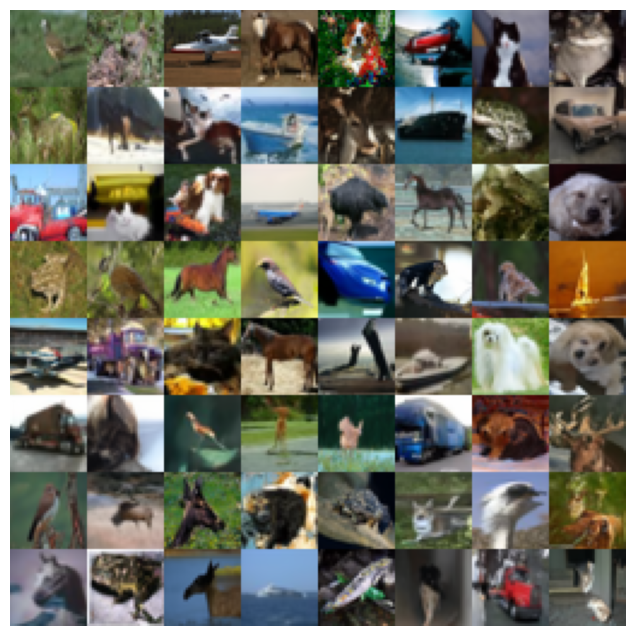

In [15]:
shape = (64, 3, 32, 32)
scaler = datasets.get_data_scaler(config)
inverse_scaler = datasets.get_data_inverse_scaler(config)
sampling_eps = 1e-5

sampling_fn = sampling.get_ode_sampler(sde,                                        
                                       shape, 
                                       inverse_scaler,                                       
                                       denoise=True, 
                                       eps=sampling_eps,
                                       device=config.device)
x, nfe = sampling_fn(score_model)
print(nfe)
show_samples(x)